In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import multivariate_normal

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# archiectures 
class net1(nn.Module):
    def __init__(self, d, h, period, num_hidden=0, num_classes=2):
        super().__init__()
        self.period = period

        self.linears = nn.ModuleList(
            [nn.Linear(d+1, h)] + 
            [nn.Linear(h, h) for _ in range(num_hidden)] + 
            [nn.Linear(h, num_classes)]
        )
        self.relu = nn.ReLU() 
        
    def modulo(self, t):
        return torch.fmod(t, self.period) / self.period

    def forward(self, x):
        u = torch.select(x, -1, 0)
        t = torch.select(x, -1, 1)
        t = self.modulo(t)
        x = torch.cat((u.view(-1, 1), t.view(-1, 1)), dim=1)
        for layer in self.linears:
            x = layer(x)
            x = self.relu(x)
        return x

class net2(nn.Module):
    def __init__(self, d, h, num_hidden=2, num_classes=2, num_periods=10):
        super().__init__()
        self.num_periods = num_periods

        self.linears = nn.ModuleList(
            [nn.Linear(d+num_periods, h)] + 
            [nn.Linear(h, h) for _ in range(num_hidden)] + 
            [nn.Linear(h, num_classes)]
        )
        self.relu = nn.ReLU() 

    def modulo_encoder(self, t):
        l = torch.arange(1, self.num_periods + 1, 1)
        t_aug = torch.ones((len(l), len(t))) * t
        return torch.fmod(torch.transpose(t_aug, 1, 0), l) / l

    def cosine_encoder(self, t):
        l = torch.arange(1, self.periods + 1, 1)
        t_aug = torch.ones((len(l), len(t))) * t
        return torch.cos(2 * np.pi * torch.transpose(t_aug, 1, 0) / l)

    def forward(self, x):
        u = torch.select(x, -1, 0)
        t = torch.select(x, -1, 1)
        t = self.modulo_encoder(t)
        x = torch.cat((u.view(-1, 1), t), dim=1)
        for layer in self.linears:
            x = layer(x)
            x = self.relu(x)
        return x

In [7]:
# functions
def sample_from_task_sequence(t, N=10):
    if (t // (N/2)) % 2 == 0:
        mu = 1
    else:
        mu = -1
    Y = np.random.binomial(1, 0.5)
    X = np.random.normal((-1)**(Y+1)*mu, 0.5)
    return X, t, Y

def get_dataloader(X, Y):
    torch_X = torch.Tensor(X)
    torch_Y = torch.Tensor(Y)
    dataset = TensorDataset(torch_X, torch_Y)
    trainloader = DataLoader(dataset, batch_size=64, shuffle=True)
    return trainloader

def train(model, trainloader, num_epochs, lr=0.01, verbose=False):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train()
        nb_batches = len(trainloader)
        losses = 0.0
        train_acc = 0.0
        for x, y in trainloader:
            x = x.to(device)
            y = y.long().to(device)

            out = model(x)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            losses += loss.item()
            optimizer.step()
            train_acc += (out.argmax(1) == y).cpu().numpy().mean()
        scheduler.step()
        if verbose and epoch % 100 == 0:
            print("Training loss at epoch {} : {:4f}, Training Acc : {:4f}".format(epoch+1, losses/nb_batches, train_acc/nb_batches))
    return model

def compute_cumulative_error(model, t, N, T, num_reps=10):
    preds = []
    gts = []
    model.eval()
    for rep in range(num_reps):
        testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, T)])
        Xt = torch.Tensor(testdata[:, :-1])
        Yt = testdata[:, -1]
        out = model(Xt)
        preds.append(out.detach().argmax(1).numpy())
        gts.append(Yt)
    preds = np.array(preds)
    gts = np.array(gts)
    mean_error = np.mean(preds != gts)
    std_error = np.std(preds != gts)
    return mean_error, std_error

### When the period is known

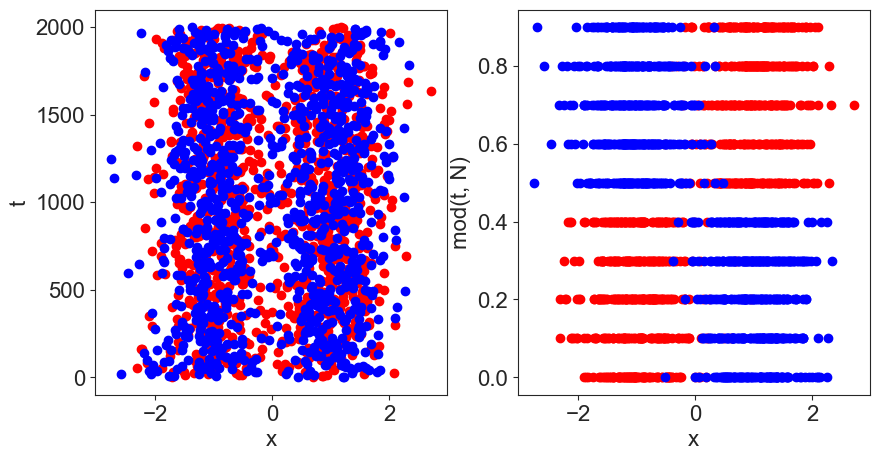

In [352]:
N = 10
t = 2000

data = np.array([sample_from_task_sequence(s, N) for s in range(0, t)])
X = data[:, :-1]
Y = data[:, -1]

fig, axes = plt.subplots(1, 2, figsize=(10,5))
ax = axes[0]
ax.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='red', label="class 0")
ax.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='blue', label="class 1")
ax.set_xlabel("x")
ax.set_ylabel("t")

X[:, 1] = np.mod(X[:, 1], N) / N
ax = axes[1]
ax.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='red', label="class 0")
ax.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='blue', label="class 1")
ax.set_xlabel("x")
ax.set_ylabel("mod(t, N)")
plt.show()

In [389]:
N = 10
t = 2000

np.random.seed(1996)
data = np.array([sample_from_task_sequence(s, N) for s in range(0, t)])
X = data[:, :-1]
Y = data[:, -1]
trainloader = get_dataloader(X, Y)

In [395]:
model = net1(d=1, h=50, period=N, num_hidden=2, num_classes=2)
model.to(device)
model = train(model, trainloader, num_epochs=1000, verbose=True)

Training loss at epoch 1 : 0.693682, Training Acc : 0.477051
Training loss at epoch 101 : 0.128396, Training Acc : 0.972656
Training loss at epoch 201 : 0.082273, Training Acc : 0.975098
Training loss at epoch 301 : 0.070749, Training Acc : 0.974609
Training loss at epoch 401 : 0.065024, Training Acc : 0.974609
Training loss at epoch 501 : 0.067587, Training Acc : 0.970215
Training loss at epoch 601 : 0.062231, Training Acc : 0.971680
Training loss at epoch 701 : 0.060832, Training Acc : 0.976562
Training loss at epoch 801 : 0.062778, Training Acc : 0.972168
Training loss at epoch 901 : 0.060866, Training Acc : 0.973145


In [396]:
num_reps = 100
preds = []
gts = []
model.eval()
for rep in range(num_reps):
    testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, 2*t)])
    Xt = torch.Tensor(testdata[:, :-1])
    Yt = testdata[:, -1]
    out = model(Xt)
    preds.append(out.detach().argmax(1).numpy())
    gts.append(Yt)
preds = np.array(preds)
gts = np.array(gts)
mean_error = np.mean(preds != gts, axis=0)
std_error = np.std(preds != gts, axis=0)
ci = std_error * 1.96/np.sqrt(num_reps)

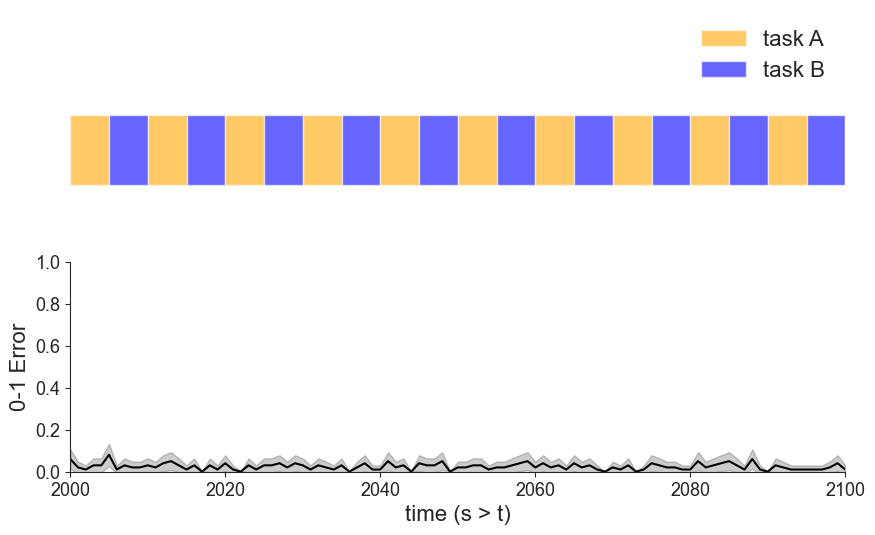

In [397]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ax = axes[0]
end = 100+1
future = np.arange(t, t+end, 1)
errors = mean_error[:end]
c = ci[:end]
xlocs = np.arange(t, t+end, N/2)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(future, errors, c='k')
ax.fill_between(future, errors-c, errors+c, alpha=0.2, color='k')
ax.set_ylabel("0-1 Error", fontsize=16)
ax.set_xlabel("time (s > t = {})".format(t), fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.set_ylim([0, 1])
plt.show()


### When the period is not known

In [398]:
N = 10
t = 2000

np.random.seed(1996)
data = np.array([sample_from_task_sequence(s, N) for s in range(0, t)])
X = data[:, :-1]
Y = data[:, -1]
trainloader = get_dataloader(X, Y)

In [399]:
model = net2(d=1, h=50, num_periods=20, num_hidden=3, num_classes=2)
model.to(device)
model = train(model, trainloader, num_epochs=1000, verbose=True)

Training loss at epoch 1 : 0.692797, Training Acc : 0.520020
Training loss at epoch 101 : 0.691140, Training Acc : 0.522949
Training loss at epoch 201 : 0.686805, Training Acc : 0.526855
Training loss at epoch 301 : 0.580546, Training Acc : 0.713867
Training loss at epoch 401 : 0.051562, Training Acc : 0.979004
Training loss at epoch 501 : 0.038679, Training Acc : 0.983398
Training loss at epoch 601 : 0.031143, Training Acc : 0.991211
Training loss at epoch 701 : 0.014232, Training Acc : 0.996582
Training loss at epoch 801 : 0.013508, Training Acc : 0.996094
Training loss at epoch 901 : 0.005532, Training Acc : 0.999512


In [400]:
num_reps = 100
preds = []
gts = []
model.eval()
for rep in range(num_reps):
    testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, 2*t)])
    Xt = torch.Tensor(testdata[:, :-1])
    Yt = testdata[:, -1]
    out = model(Xt)
    preds.append(out.detach().argmax(1).numpy())
    gts.append(Yt)
preds = np.array(preds)
gts = np.array(gts)
mean_error = np.mean(preds != gts, axis=0)
std_error = np.std(preds != gts, axis=0)
ci = std_error * 1.96/np.sqrt(num_reps)

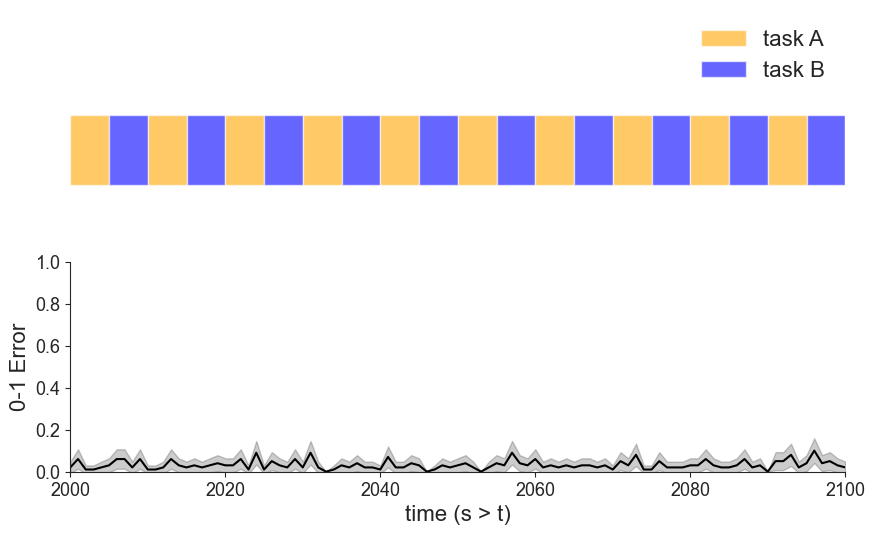

In [401]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ax = axes[0]
end = 100+1
future = np.arange(t, t+end, 1)
errors = mean_error[:end]
c = ci[:end]
xlocs = np.arange(t, t+end, N/2)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(future, errors, c='k')
ax.fill_between(future, errors-c, errors+c, alpha=0.2, color='k')
ax.set_ylabel("0-1 Error", fontsize=16)
ax.set_xlabel("time (s > t = {})".format(t), fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.set_ylim([0, 1])
plt.show()


### time vs. cumulative risk over the future plot

In [11]:
N = 10
t_list = [100, 500, 1000, 1500, 2000]
T = 5000
num_epochs = 6000
num_reps = 100

data = np.array([sample_from_task_sequence(s, N) for s in range(0, t_list[-1])])

In [12]:
cumulative_error = []
std_cumulative_error = []
for t in t_list:
    print(t)
    data_t = data[:t]
    X = data_t[:, :-1]
    Y = data_t[:, -1]
    trainloader = get_dataloader(X, Y)
    model = net2(d=1, h=50, num_periods=20, num_hidden=3, num_classes=2)
    model.to(device)
    model = train(model, trainloader, num_epochs, verbose=False)
    mean_err, std_err = compute_cumulative_error(model, t, N, T, num_reps)
    cumulative_error.append(mean_err)
    std_cumulative_error.append(std_err)
cumulative_error = np.array(cumulative_error)
std_cumulative_error = np.array(std_cumulative_error)
ci = std_cumulative_error * 1.96 / np.sqrt(num_reps)

100
500
1000
1500
2000


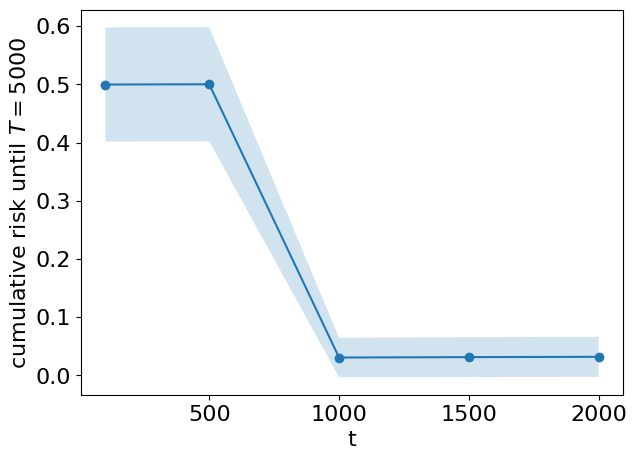

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(t_list, cumulative_error, 'o-')
ax.fill_between(t_list, cumulative_error-ci, cumulative_error+ci, alpha=0.2)
ax.set_xlabel('t')
ax.set_ylabel(r'cumulative risk until $T = {}$'.format(T))
plt.show()